# Introduction

# Competition's Description

The goal of this [competition](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview) is to predict student performance during a game-based learning in real-time. In this notebook we'll develop a model trained on one of the largest open datasets of game logs to try to predict student performance.

# Setup

In [96]:
%pip install numpy pandas matplotlib seaborn sklearn

Note: you may need to restart the kernel to use updated packages.


In [97]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup matplotlib
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [98]:
# Path to files
test_csv_path = "./data/test.csv"
train_csv_path = "./data/train.csv"
train_labels_csv = "./data/train_labels.csv"

sample_submission_csv = "./data/sample_submission.csv"

To see what does each column is in each dataset, you can find the data dictionary [here](https://www.kaggle.com/c/predict-student-performance-from-game-play/data).

Since the train dataset is quite large, we'll start by loading only a subset of it. This will allow us to explore the data and perform some basic analysis and feature engineering more quickly.

In [99]:
# Read train dataset
train_df = pd.read_csv(train_csv_path, index_col="index", nrows=10_000)
train_df.head()

,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [100]:
# Read train labels dataset
labels_df = pd.read_csv(train_labels_csv)
labels_df.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [101]:
# Read test dataset
test_df = pd.read_csv(test_csv_path, index_col="index")
test_df.head()

,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
index,,,,,,,,,,,,,,,,,,,,
0,20090109393214576,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,259.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0
1,20090109393214576,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,398.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
2,20090109393214576,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,287.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
3,20090109393214576,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
4,20090109393214576,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0


# Memory optimization

We'll start by optimizing the memory usage of the dataset. This is due to the fact that the dataset is not only quite large but also because in the competition is specified that the memory consumption and efficiency of the model is a key factor. We also think that this is a good practice to follow in general.

In [102]:
# Check the shape of the train dataset
train_df.shape

(10000, 19)

In [103]:
# Check memory usage of the train dataset
train_df.memory_usage(deep=True)

Index              80000
session_id         80000
elapsed_time       80000
event_name        700443
name              638871
level              80000
page               80000
room_coor_x        80000
room_coor_y        80000
screen_coor_x      80000
screen_coor_y      80000
hover_duration     80000
text              525518
fqid              567025
room_fqid         847275
text_fqid         569413
fullscreen         80000
hq                 80000
music              80000
level_group       614050
dtype: int64

In [104]:
# Check total memory usage as megabytes
train_df.memory_usage(deep=True).sum() / 1024**2

5.247683525085449

In [105]:
# Get column names
train_df.columns

Index(['session_id', 'elapsed_time', 'event_name', 'name', 'level', 'page',
       'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

In [106]:
# Check the types of the data
train_df.dtypes

session_id          int64
elapsed_time        int64
event_name         object
name               object
level               int64
page              float64
room_coor_x       float64
room_coor_y       float64
screen_coor_x     float64
screen_coor_y     float64
hover_duration    float64
text               object
fqid               object
room_fqid          object
text_fqid          object
fullscreen          int64
hq                  int64
music               int64
level_group        object
dtype: object

In [107]:
# Number of nan values in each column
train_df.isna().sum()

session_id           0
elapsed_time         0
event_name           0
name                 0
level                0
page              9766
room_coor_x       1015
room_coor_y       1015
screen_coor_x     1015
screen_coor_y     1015
hover_duration    9013
text              6368
fqid              3031
room_fqid            0
text_fqid         6368
fullscreen           0
hq                   0
music                0
level_group          0
dtype: int64

In [108]:
# Number of unique values in each column
train_df.nunique()

session_id          10
elapsed_time      9980
event_name          11
name                 6
level               23
page                 7
room_coor_x       8669
room_coor_y       7243
screen_coor_x     1011
screen_coor_y      704
hover_duration     490
text               522
fqid               118
room_fqid           19
text_fqid          104
fullscreen           2
hq                   2
music                2
level_group          3
dtype: int64

Since some columns like `fullscreen`, `hq` and `music` are binary, we can change their type to `bool` to save some memory.

In [109]:
# Change the type of `fullscreen`, `hq` and `music` column to `bool`
train_df["fullscreen"] = train_df["fullscreen"].astype("bool")
train_df["hq"] = train_df["hq"].astype("bool")
train_df["music"] = train_df["music"].astype("bool")

In [110]:
# Check the `event_name` column
train_df["event_name"].value_counts()

event_name
navigate_click        4152
person_click          2256
cutscene_click        1035
object_click           736
map_hover              539
object_hover           448
notification_click     262
notebook_click         234
map_click              231
observation_click       79
checkpoint              28
Name: count, dtype: int64

Since the `event_name` column has a few different values, we can change its type to `category` to also save memory. We can also do the same for the `name` column.

In [111]:
# Convert `event_name` and `name` columns to categorical
train_df["event_name"] = train_df["event_name"].astype("category")
train_df["name"] = train_df["name"].astype("category")

In [112]:
# Check the `level` column range of values
train_df["level"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [113]:
# Convert `level` column to `int8` to save memory since the range of values is between 0 and 22, which is way less than 128
train_df["level"] = train_df["level"].astype("int8")

In [114]:
# Check the `page` column
train_df["page"].value_counts()

page
6.0    57
5.0    44
1.0    38
4.0    35
0.0    31
3.0    22
2.0     7
Name: count, dtype: int64

In [115]:
# As with `level`, we can convert `page` to `int8` to save memory but since it contains some nan values, instead of converting it to `int8`, we will convert it to `Int8` which is a nullable integer
train_df["page"] = train_df["page"].astype("Int8")

In [116]:
# Check the `level_group` column
train_df["level_group"].value_counts()

level_group
13-22    5573
5-12     2904
0-4      1523
Name: count, dtype: int64

In [117]:
# Since the `level_group` column contains only 3 unique values, we can also convert it to `category`
level_group_cat_type = pd.CategoricalDtype(categories=["0-4", "5-12", "13-22"], ordered=True)
train_df["level_group"] = train_df["level_group"].astype(level_group_cat_type)

In [118]:
# Check the `fqid` column
train_df["fqid"].value_counts()

fqid
worker                          661
gramps                          451
archivist                       421
toentry                         307
wells                           278
                               ... 
reader.paper0.prev                2
reader.paper2.prev                2
tocloset                          2
reader.paper1.prev                1
journals_flag.pic_1_old.next      1
Name: count, Length: 118, dtype: int64

In [119]:
# Check the `room_fqid` column
train_df["room_fqid"].value_counts()

room_fqid
tunic.historicalsociety.entry              1517
tunic.wildlife.center                      1055
tunic.historicalsociety.cage                786
tunic.library.frontdesk                     772
tunic.historicalsociety.stacks              705
tunic.historicalsociety.frontdesk           703
tunic.historicalsociety.closet_dirty        603
tunic.humanecology.frontdesk                499
tunic.kohlcenter.halloffame                 479
tunic.historicalsociety.basement            439
tunic.drycleaner.frontdesk                  367
tunic.historicalsociety.collection          354
tunic.historicalsociety.closet              339
tunic.library.microfiche                    327
tunic.flaghouse.entry                       313
tunic.capitol_2.hall                        274
tunic.capitol_1.hall                        191
tunic.historicalsociety.collection_flag     176
tunic.capitol_0.hall                        101
Name: count, dtype: int64

In [120]:
# Check the `text_fqid` column
train_df["text_fqid"].value_counts()

text_fqid
tunic.historicalsociety.cage.confrontation                     212
tunic.historicalsociety.entry.groupconvo                       184
tunic.wildlife.center.crane_ranger.crane                       164
tunic.historicalsociety.frontdesk.archivist.newspaper          164
tunic.historicalsociety.frontdesk.archivist.have_glass         156
                                                              ... 
tunic.capitol_2.hall.chap4_finale_c                              1
tunic.capitol_1.hall.boss.writeitup                              1
tunic.capitol_1.hall.chap2_finale_c                              1
tunic.humanecology.frontdesk.block_0                             1
tunic.historicalsociety.frontdesk.archivist.newspaper_recap      1
Name: count, Length: 104, dtype: int64

In [121]:
# We think that we can also convert `fquid`, `room_fqid` and `text_fqid` to `category` without losing any information
train_df["fqid"] = train_df["fqid"].astype("category")
train_df["room_fqid"] = train_df["room_fqid"].astype("category")
train_df["text_fqid"] = train_df["text_fqid"].astype("category")

Some columns like `room_coor_x`, `room_coor_y`, `screen_coor_x`, `screen_coor_y` and `hover_duration` have a float64 type but looking at the data we can see that maybe they could be converted to float32 without a loss in information.

In [122]:
# Get max value of `room_coor_x` column
train_df["room_coor_x"].max()

1234.4698376483232

In [123]:
# Get max value of `room_coor_y` column
train_df["room_coor_y"].max()

484.99533347049936

In [124]:
# Get max value of `hover_duration` column
train_df["hover_duration"].max()

26695.0

In [125]:
# Convert `room_coor_x`, `room_coor_y`, `screen_coor_x`, `screen_coor_y` and `hover_duration` to float32
train_df["room_coor_x"] = train_df["room_coor_x"].astype("float32")
train_df["room_coor_y"] = train_df["room_coor_y"].astype("float32")
train_df["screen_coor_x"] = train_df["screen_coor_x"].astype("float32")
train_df["screen_coor_y"] = train_df["screen_coor_y"].astype("float32")

We can also check if the `elapsed_time` column can be converted to a int32 type. We can do this by checking if the maximum value of the column.

In [126]:
# Get max value of `elapsed_time` column
train_df["elapsed_time"].max()

4208427

In [127]:
# Convert `elapsed_time` to `int32`
train_df["elapsed_time"] = train_df["elapsed_time"].astype("int32")

Finally, we can convert the `text` column to `string` type.

In [128]:
# Convert `text` column to str
train_df["text"] = train_df["text"].astype("str")

In [129]:
# Check again the memory usage
train_df.memory_usage(deep=True)

Index              80000
session_id         80000
elapsed_time       40000
event_name         11068
name               10545
level              10000
page               20000
room_coor_x        40000
room_coor_y        40000
screen_coor_x      40000
screen_coor_y      40000
hover_duration     80000
text              703822
fqid               22548
room_fqid          12160
text_fqid          24655
fullscreen         10000
hq                 10000
music              10000
level_group        10291
dtype: int64

In [130]:
# Check again the total memory usage (as megabytes)
train_df.memory_usage(deep=True).sum() / 1024**2

1.235093116760254

In [131]:
train_df.head()

,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,False,False,True,0-4
1,20090312431273200,1323,person_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4
2,20090312431273200,831,person_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4
3,20090312431273200,1147,person_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4
4,20090312431273200,1863,person_click,basic,0,<NA>,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4


As we can see we have reduced the memory usage drastically by just converting some columns to categorical types and other to more efficient types for the data they contain. This will allow us to load the full dataset later more efficiently and to be able to iterate faster over the data when needed.  

We don't think that we can reduce much more the memory usage of the dataset, so now we'll load the full train dataset and start exploring it a bit more.

# Data loading

In [132]:
# Try to import full train dataset with better types
train_df = pd.read_csv(train_csv_path, index_col="index", dtype={
    "session_id": "int64",
    "elapsed_time": "int32",
    "event_name": "category",
    "name": "category",
    "level": "int8",
    "page": "Int8",
    "room_coor_x": "float32",
    "room_coor_y": "float32",
    "screen_coor_x": "float32",
    "screen_coor_y": "float32",
    "hover_duration": "float32",
    "text": "str",
    "fqid": "category",
    "room_fqid": "category",
    "text_fqid": "category",
    "fullscreen": "bool",
    "hq": "bool",
    "music": "bool",
    "level_group": level_group_cat_type
})

In [133]:
# Check full train dataset memory usage (as megabytes)
train_df.memory_usage(deep=True).sum() / 1024**2

2649.321762084961

In [134]:
train_df.head()

,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,False,False,True,0-4
1,20090312431273200,1323,person_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4
2,20090312431273200,831,person_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4
3,20090312431273200,1147,person_click,basic,0,<NA>,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4
4,20090312431273200,1863,person_click,basic,0,<NA>,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,False,False,True,0-4


The other important dataset is the labels dataset. We'll load it and see how it relates to the train dataset.

In [135]:
# Load train labels dataset
labels_df = pd.read_csv(train_labels_csv)

In [136]:
labels_df.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


We can see how the labels have a `session_id` column that contains the session id and the question number. We'll extract this information and create a new column with the question number.

In [137]:
# Split `session_id` column to get question number
labels_df[["session_id", "question_number"]] = labels_df["session_id"].str.split("_", expand=True)

In [138]:
labels_df.head()

,session_id,correct,question_number
0,20090312431273200,1,q1
1,20090312433251036,0,q1
2,20090312455206810,1,q1
3,20090313091715820,0,q1
4,20090313571836404,1,q1


In [139]:
# Check the `question_number` column
labels_df["question_number"].value_counts()

question_number
q1     23562
q2     23562
q17    23562
q16    23562
q15    23562
q14    23562
q13    23562
q12    23562
q11    23562
q10    23562
q9     23562
q8     23562
q7     23562
q6     23562
q5     23562
q4     23562
q3     23562
q18    23562
Name: count, dtype: int64

In [140]:
# Extract question number from `question_number` column and convert it to `int8`
labels_df["question_number"] = labels_df["question_number"].str.extract("(\d+)").astype("int8")

In [141]:
# Convert `correct` and `question_number` columns to bool and category respectively
labels_df["correct"] = labels_df["correct"].astype("bool")

# EDA

In [144]:
# Setup seaborn style
sns.set_style("whitegrid")

In [145]:
# Check number of nan values in each column
train_df.isna().sum()

session_id               0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'page'),
  Text(1, 0, 'hover_duration'),
  Text(2, 0, 'text'),
  Text(3, 0, 'text_fqid'),
  Text(4, 0, 'fqid'),
  Text(5, 0, 'screen_coor_y'),
  Text(6, 0, 'room_coor_x'),
  Text(7, 0, 'room_coor_y'),
  Text(8, 0, 'screen_coor_x'),
  Text(9, 0, 'room_fqid'),
  Text(10, 0, 'music'),
  Text(11, 0, 'hq'),
  Text(12, 0, 'fullscreen'),
  Text(13, 0, 'session_id'),
  Text(14, 0, 'elapsed_time'),
  Text(15, 0, 'level'),
  Text(16, 0, 'name'),
  Text(17, 0, 'event_name'),
  Text(18, 0, 'level_group')])

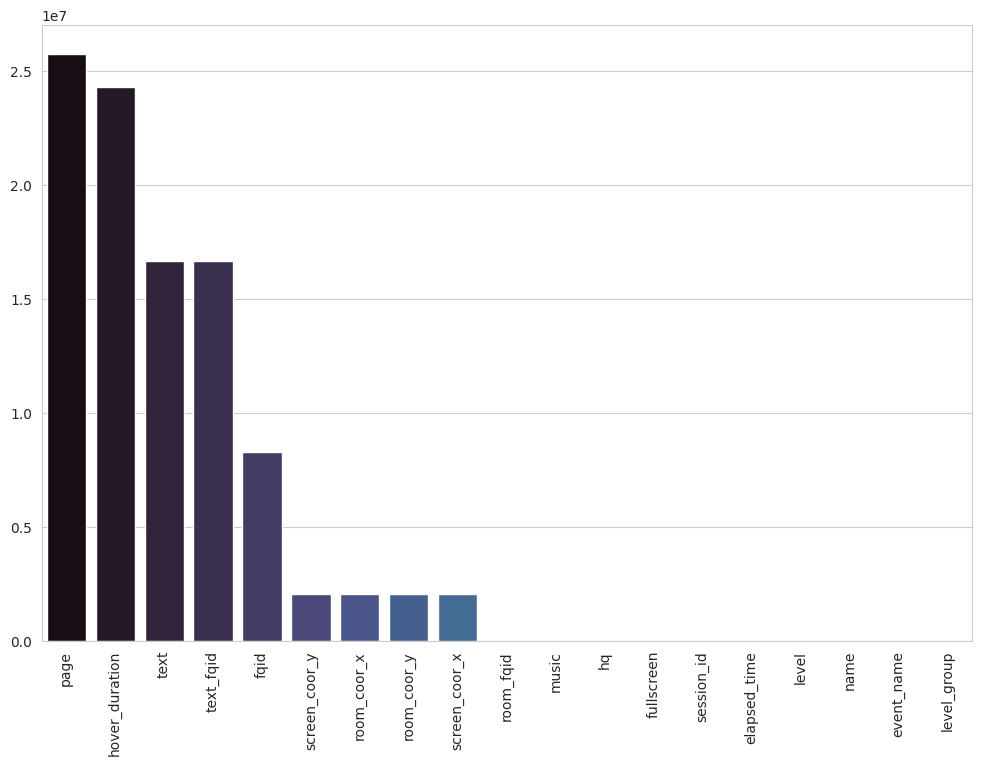

In [146]:
# Plot frequency of nan values in each column
plt.figure(figsize=(12, 8))

sns.barplot(
    x=train_df.isna().sum().index,
    y=train_df.isna().sum().values,
    order=train_df.isna().sum().sort_values(ascending=False).index,
    palette="mako"
)

plt.xticks(rotation=90)

As we can see, some columns like `page`, `hover_duration`, `text` and `text_fquid` have a lot of missing values. We'll see later how to deal with this and if this is a problem or not for the model.

Text(0.5, 1.0, 'Number of correct answers per question number')

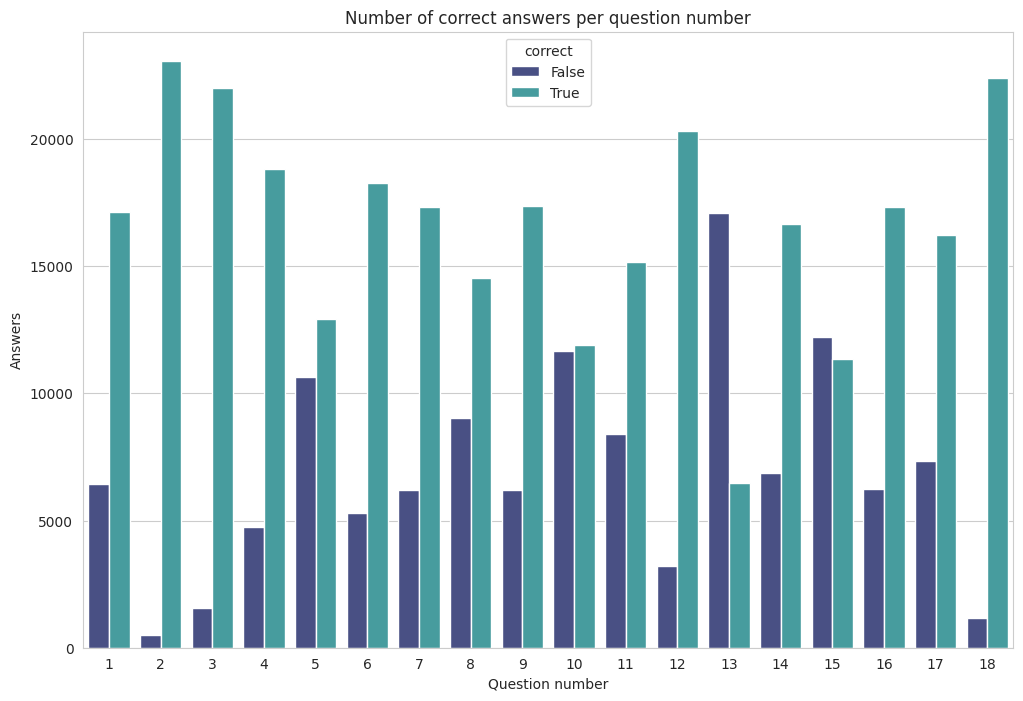

In [147]:
# Plot number of correct answers per question
plt.figure(figsize=(12, 8))

sns.countplot(
    x="question_number",
    hue="correct",
    data=labels_df,
    palette="mako"
)

plt.xlabel("Question number")
plt.ylabel("Answers")

plt.title("Number of correct answers per question number")

We can observe that some questions, ushc as 2, 3 and 18 have a higher number of correct answers, indicating that these questions maybe were relatively easier. On the other hand, questions 13 and 15 have a higher number of incorrect answers, indicating that these questions maybe were more challenging.

(500.0, 2500.0)

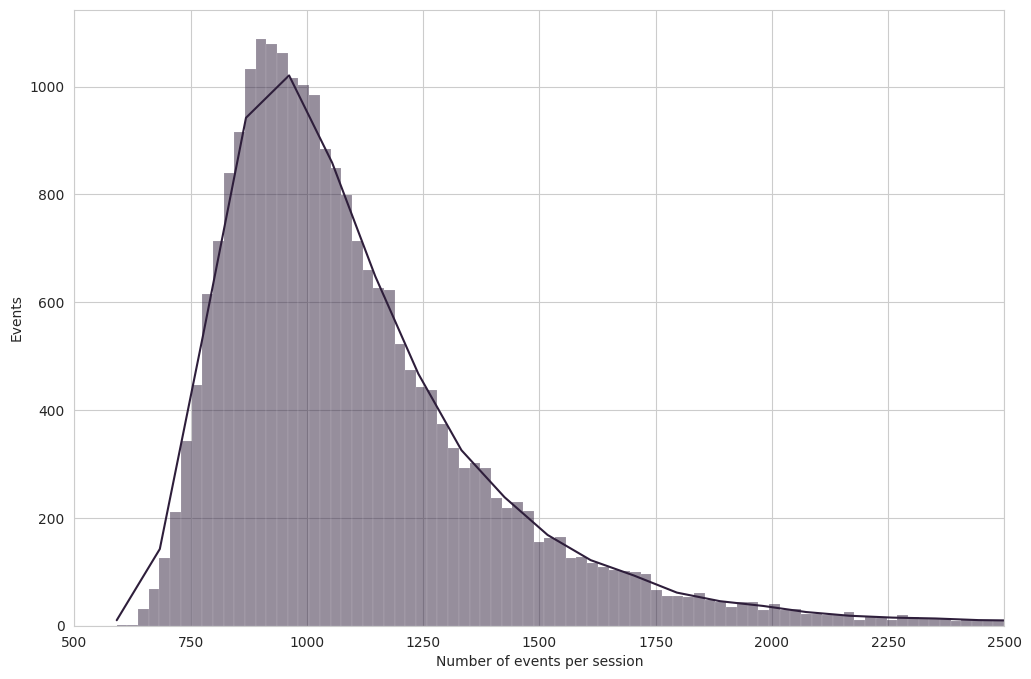

In [148]:
# Plot number of events by session
plt.figure(figsize=(12, 8))

sns.histplot(
    x=train_df["session_id"].value_counts(),
    data=train_df,
    kde=True,
    color=sns.color_palette("mako")[0],
)

plt.xlabel("Number of events per session")
plt.ylabel("Events")
plt.xlim(500, 2500)


In [149]:
# Average number of events per session
train_df["session_id"].value_counts().mean()

1116.0744418979714

In [150]:
# Total time spent by each user using elapsed time column (in minutes)
elapsed_time_min = train_df.groupby("session_id")["elapsed_time"].sum() / 60_000
elapsed_time_min

session_id
20090312431273200      9282.349917
20090312433251036     57896.157883
20090312455206810      8390.254900
20090313091715820     13388.543383
20090313571836404      7741.139200
                         ...      
22100215342220508    132394.973233
22100215460321130     18117.862167
22100217104993650     21332.451567
22100219442786200      8820.977583
22100221145014656     82537.700100
Name: elapsed_time, Length: 23562, dtype: float64

In [151]:
# Max time spent by an user
elapsed_time_min.max()

32705279.8279

In [152]:
# Min time spent by an user
elapsed_time_min.min()

6.451966666666666

In [153]:
# Average time spent by an user
elapsed_time_min.mean()

74715.48994760065

As we can see above, the maximum time spent by an user is 17805.075148065844 minutes, which is around 12.36 days. This is a very long time and it will be interesting to check the correlation between an user's session duration and the performance in the test. The minimum time spent is 0.008986 minutes. The average time spent is 62.514 minutes, which is a little more than an hour.

<Axes: xlabel='count', ylabel='event_name'>

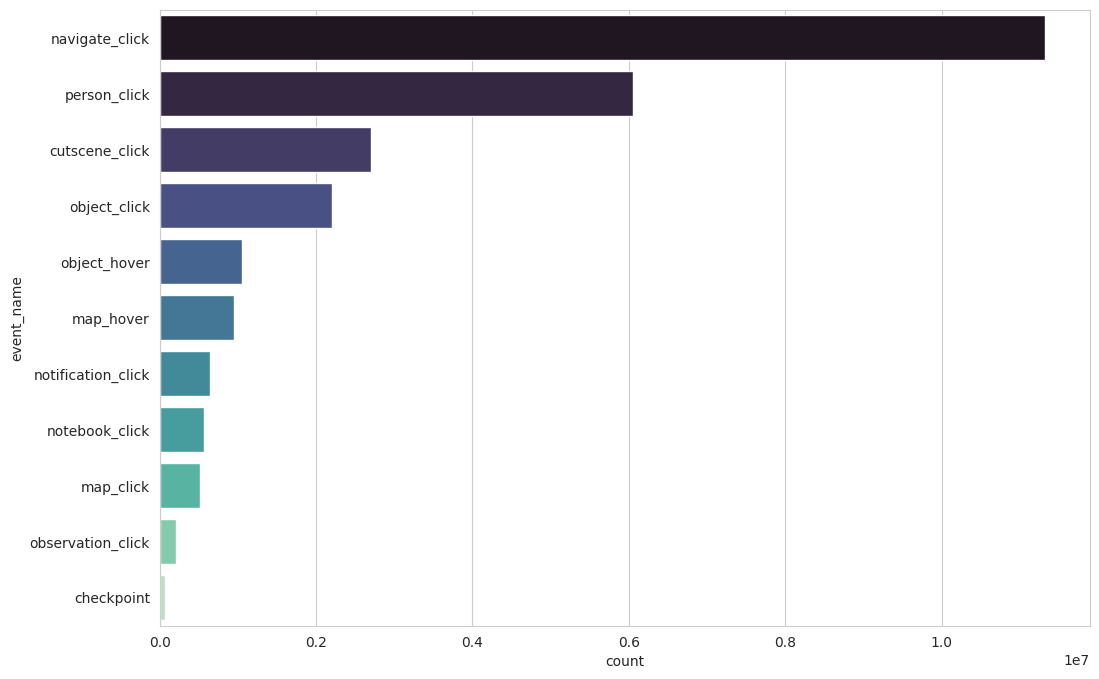

In [154]:
# Plot frequency of events
plt.figure(figsize=(12, 8))

sns.countplot(
    y="event_name",
    data=train_df,
    order=train_df["event_name"].value_counts().index,
    palette="mako"
)

In [155]:
# Number of events per level_group
counts = train_df["level_group"].value_counts().sort_index()
counts

level_group
0-4       3981005
5-12      8844238
13-22    13471703
Name: count, dtype: int64

([<matplotlib.axis.YTick at 0x7f59a1c96150>,
 [Text(0, 3981005, '3981005'),
  Text(0, 8844238, '8844238'),
  Text(0, 13471703, '13471703')])

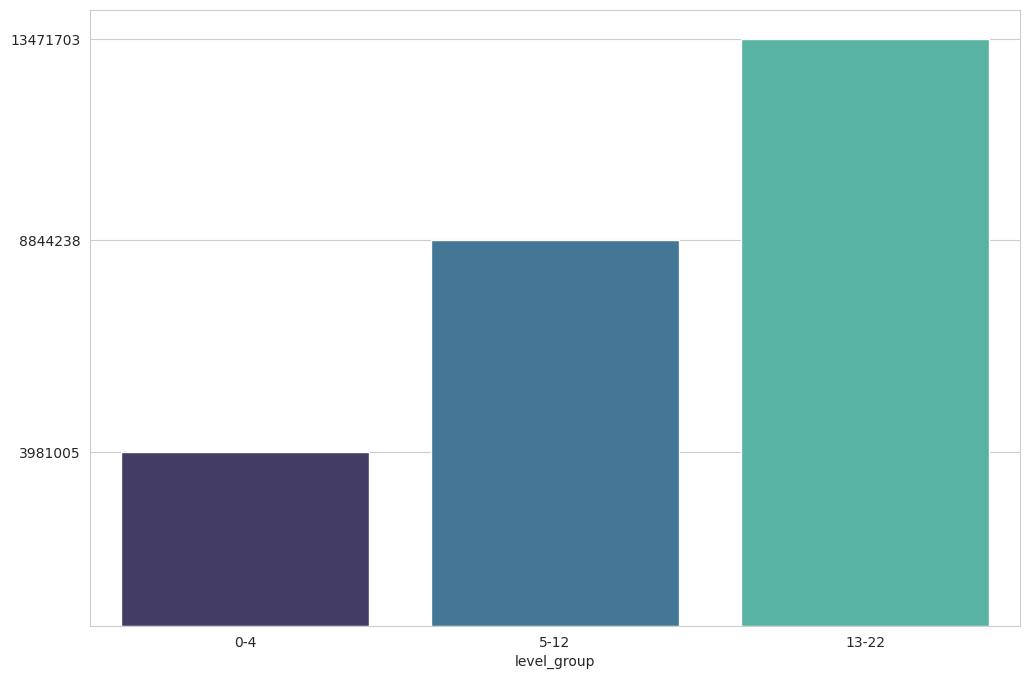

In [156]:
# Plot number of events per level_group
plt.figure(figsize=(12, 8))

sns.barplot(
    x=counts.index,
    y=counts.values,
    palette="mako"
)

plt.yticks(counts.values, counts.values)

In [157]:
# Number of events per level
counts = train_df["level"].value_counts().sort_index()
counts

level
0      688992
1      726590
2      992615
3     1144768
4      428040
5      668188
6     2117796
7     1278207
8      888584
9     1137748
10     449139
11    1937208
12     367368
13     823875
14     550829
15    1219497
16    1295082
17    1207881
18    3499163
19    1217088
20    1129246
21    2110010
22     419032
Name: count, dtype: int64

<Axes: xlabel='level'>

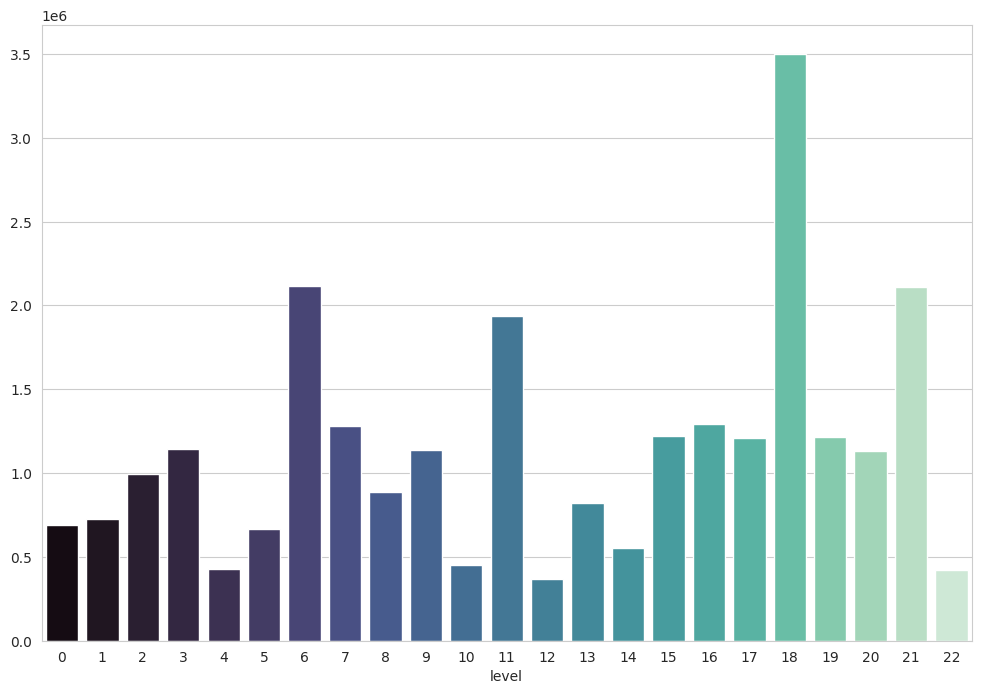

In [158]:
# Plot number of events per level
plt.figure(figsize=(12, 8))

sns.barplot(
    x=counts.index,
    y=counts.values,
    palette="mako",
)